# Segmenting NUP153

In [1]:
# import python packages
import glob
import os

# import packages
import numpy as np

import matplotlib.pyplot as plt
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

from itkwidgets import view     

# function for core algorithm
from aicssegmentation.core.vessel import filament_3d_wrapper
from aicssegmentation.core.vessel import filament_2d_wrapper
import aicssegmentation.core.seg_dot as seg_dot
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.pre_processing_utils import intensity_normalization, edge_preserving_smoothing_3d, image_smoothing_gaussian_3d
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball       # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import distance_transform_edt

In [7]:
os.getcwd()

'/allen/aics/assay-dev/users/Hyeonwoo/code/aics-segmentation'

## Loading the Data

In [2]:
# Data recognition
Data = glob.glob("../../../Segmentation/NUP153_test/original/*.czi")
print(Data)
reader = AICSImage(Data[0])
IMG = reader.data
print(IMG.shape)

[]


IndexError: list index out of range

In [36]:
Data.sort()

'../../../Segmentation/NUP153_test/original\\3500002682_100X_20190122_1-Scene-063_aligned_cropped-P63-F08.czi'

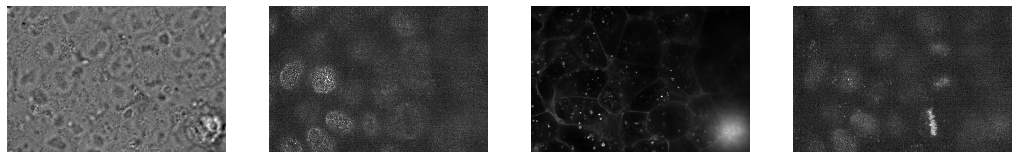

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS==1:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [15]:
# Using seco

#####################
structure_channel = 1
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x0000017F1E…

In [20]:
################################
## PARAMETERS for intensity normalization ##
intensity_scaling_param = [1, 13.5]
################################
struct_img = intensity_normalization(struct_img0.copy(), scaling_param=intensity_scaling_param)

intensity normalization: normalize into [mean - 1 x std, mean + 13.5 x std] 
intensity normalization completes


In [6]:
writer = OmeTiffWriter('//allen/aics/assay-dev/Segmentation/NUP153_test/test_intensity_norm35.tiff')
writer.save(struct_img)

In [21]:
view(single_fluorescent_view(struct_img))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x0000017F4D…

In [7]:
# Normalization suggestion

from aicssegmentation.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(struct_img0)

mean intensity of the stack: 416.8011687749288
the standard deviation of intensity of the stack: 10.262218608045787
0.9999 percentile of the stack intensity is: 460.0
minimum intensity of the stack: 404
maximum intensity of the stack: 460
suggested upper range is 4.0, which is 457.8500432071119
suggested lower range is 1.0, which is 406.538950166883
So, suggested parameter for normalization is [1.0, 4.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


In [27]:
################################
## PARAMETERS for smoothing ##
gaussian_smoothing_sigma = 1
################################

# 3d gaussian smoothing makes more sense
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

# edge-preserving smoothing
#structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

In [28]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x0000017F00…

In [33]:
################################
## PARAMETERS for this step ##
s3_param = [[1, 0.03]]
################################

bw_3d = seg_dot.dot_3d_wrapper(structure_img_smooth, s3_param)

In [34]:
# visualization
viewer_bw_3d = view(segmentation_quick_view(bw_3d))
viewer_bw_3d

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x0000017F…

In [35]:
out=bw_3d.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter('//allen/aics/assay-dev/Segmentation/NUP153_test/test_gs_s3_1_003.tiff')
writer.save(out)

In [19]:
# watershed
minArea = 4
Mask = remove_small_objects(bw_3d>0, min_size=minArea, connectivity=1, in_place=False) 
Seed = dilation(peak_local_max(struct_img,labels=label(Mask), min_distance=2, indices=False), selem=ball(1))
Watershed_Map = -1*distance_transform_edt(bw)
seg = watershed(Watershed_Map, label(Seed), mask=Mask, watershed_line=True)

################################
## PARAMETERS for this step ##
minArea = 50
################################

final_seg = remove_small_objects(seg>0, min_size=minArea, connectivity=1,in_place=False)

viewer_final_3d = view(segmentation_quick_view(final_seg))
viewer_final_3d

KeyboardInterrupt: 

In [13]:
# hole_filling parameter
hole_param = [10,30]
final_seg_holes = hole_filling(bw_3d>0, hole_param[0], hole_param[1]) 

################################
## PARAMETERS for this step ##
minArea = 50
################################

final_seg = remove_small_objects(final_seg_holes>0, min_size=minArea, connectivity=1,in_place=False)

In [14]:
viewer_final_3d = view(segmentation_quick_view(final_seg))
viewer_final_3d

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x00000227…

In [39]:
out=final_seg.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter('//allen/aics/assay-dev/Segmentation/NUP153_test/test.tiff')
writer.save(out)

In [49]:
writer = OmeTiffWriter('//allen/aics/assay-dev/Segmentation/NUP153_test/test_struct.tiff')
writer.save(struct_img0)

In [4]:
for x in range(6,6+1):
    print(x)

6
